# Reproductions of figure 3

In [1]:
import sys
sys.path.append("../")

import os
from pathlib import Path
import pickle
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import torch
import torch.nn as nn

from ei import topology_of, ei_of_layer

## Colormaps

In [2]:
def greyscaleMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("binary")
    return colormap((((0.6 / size * pos) + 0.1)))
                    
def rainbowMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("rainbow")
    return colormap(1.0 * pos / size)

def magmaMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("magma")
    return colormap(0.7 * pos / size + 0.2)

def blueMap(collection, item):
    size = len(collection)
    pos = collection.index(item)
    colormap = matplotlib.cm.get_cmap("Blues")
    return colormap(0.85 * pos / size + 0.15) # avoid using the lightest blue color -- it's not visible

## Set device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)
print(f"Using device: {device}")

Using device: cuda


## Define initializers

In [4]:
initializers = {
    'kaiming': None, # (default)
    'xavier_uniform': nn.init.xavier_uniform_,
    'xavier_normal': nn.init.xavier_normal_,
    'paper': nn.init.uniform_
}

def weight_initializer(name):
    def init_weights(m):
        if name == 'kaiming':
            return
        if name == 'paper':
            if isinstance(m, nn.Linear):
                boundary = 1 / np.sqrt(m.in_features)
                nn.init.uniform_(m.weight, a=-boundary, b=boundary)
        elif isinstance(m, nn.Linear):
            initializers[name](m.weight)
    return init_weights

In [7]:
widths = [8, 16, 32, 64, 128, 256, 512]

sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 
                15000, 20000, 30000, 40000, 50000, 75000, 100000, 200000,
                300000, 500000, 800000]

## Compute EI on lots of different networks with lots of different samples sizes, and save data... this takes a very long time to finish!

In [ ]:
eis = defaultdict(list)

for width in widths:
    network = nn.Linear(width, width, bias=False).to(device)
    top = topology_of(network, input=torch.zeros((1, width)).to(device))
    network.apply(weight_initializer('paper'))
    for size in sample_sizes:
        EI = ei_of_layer(network, top, 
                         samples=size, 
                         batch_size=300, 
                         in_range=(0, 1),
                         in_bins=64,
                         out_range=(0, 1),
                         out_bins=64,
                         activation=nn.Sigmoid(),
                         device=device)
        eis[width].append(EI)
    print("done with {}".format(width))

with open("saved_data/convergence.pkl", "wb") as f:
    pickle.dump(eis, f)

## Load data

In [6]:
with open("saved_data/convergence.pkl", "rb") as f:
    eis = pickle.load(f)

## Plot convergence of multiple networks at varying sample sizes with fixed bin size

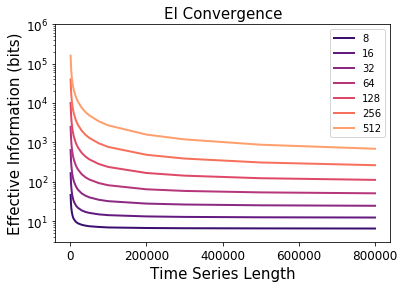

In [8]:
fig = plt.figure()
ax = fig.gca()

for width in widths:
    plt.plot(sample_sizes, eis[width], label=str(width), color=magmaMap(widths, width), linewidth=2)
    
ax.set_title("EI Convergence", fontsize=15)
ax.set_xlabel('Time Series Length', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
plt.yscale('log')
plt.ylim(3, 1000000)
# plt.xlim(0, 650000)

ax.tick_params(axis='both', which='major',labelsize=12)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200000))

plt.autoscale(False)

plt.legend(loc='upper right') #, title="width")

# plt.savefig("figures/convergence/convergence_standard", dpi=300, bbox_inches='tight')

## Let's now instead of plotting the EI vs samples for different layer widths, let's fix the layer width and instead plot for different number of bins.

In [9]:
sample_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 
                15000, 20000, 30000, 40000, 50000, 75000, 100000, 200000,
                300000, 500000, 800000]
bin_sizes = [8, 16, 32, 64, 128]

eis = defaultdict(list)

width = 30
network = nn.Linear(width, width, bias=False).to(device)
top = topology_of(network, input=torch.zeros((1, width)).to(device))
network.apply(weight_initializer('paper'))

for bins in bin_sizes:
    for size in sample_sizes:
        EI = ei_of_layer(network, top, 
                         samples=size, 
                         batch_size=100, 
                         activation=nn.Sigmoid(),
                         in_range=(0, 1),
                         in_bins=bins,
                         out_range=(0, 1),
                         out_bins=bins,
                         device=device)
        eis[bins].append(EI)
    print("done with {}".format(bins))

done with 8
done with 16
done with 32
done with 64
done with 128


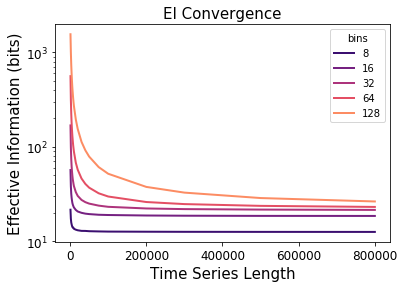

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()

for bins in bin_sizes:
    plt.plot(sample_sizes, eis[bins], label=str(bins), color=magmaMap(bin_sizes, bins), linewidth=2)
    
ax.set_title("EI Convergence", fontsize=15)
ax.set_xlabel('Time Series Length', fontsize=15)
ax.set_ylabel('Effective Information (bits)', fontsize=15)
plt.yscale('log')
# plt.ylim(8, 500)
#plt.xlim(0, 650000)

ax.tick_params(axis='both', which='major',labelsize=12)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(200000))


plt.legend(loc='upper right', title="bins")

# plt.savefig("figures/convergence/convergence_standard_varying_bins_30_wide", dpi=300, bbox_inches='tight')